Regular imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
import math

Import dataset, import targets, make combined dataset. 

In [30]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index)) #shuffle data to avoid ordering effects when using gradient descent for minimisation
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe = california_housing_dataframe[california_housing_dataframe['median_house_value'] < 490.0]
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16131.000000,16131.000000,16131.000000,16131.000000,16131.000000,16131.000000,16131.000000,16131.000000,16131.000000
mean,-119.554302,35.646260,28.307978,2628.919410,541.699027,1447.042899,503.318827,3.678975,191.543965
std,2.007124,2.152274,12.499647,2182.753276,423.942582,1160.743329,386.699625,1.570449,96.537737
min,-124.350000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14.999000
25%,-121.750000,33.930000,18.000000,1452.000000,298.000000,800.000000,283.000000,2.523400,116.300000
50%,-118.490000,34.260000,28.000000,2112.000000,436.000000,1181.000000,410.000000,3.454500,173.500000
75%,-117.990000,37.730000,37.000000,3126.000000,650.500000,1746.000000,607.000000,4.593800,247.200000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,489.600000


In [31]:
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
5712,-118.19,34.12,35.0,2524.0,749.0,2487.0,679.0,2.4932,167.7
16245,-122.48,37.64,7.0,120.0,21.0,50.0,27.0,12.5000,281.0
395,-116.94,32.84,32.0,1607.0,253.0,778.0,262.0,4.5278,166.3
3496,-117.90,33.92,27.0,698.0,116.0,391.0,126.0,5.9177,267.6
11500,-121.26,38.68,4.0,3080.0,827.0,1195.0,683.0,2.7477,133.0


In [32]:
all_features = list(california_housing_dataframe)
all_features.remove('median_house_value')
all_features

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

Define function that takes in full data set and returns features data set, including synthetic features Ideas: scale population, clip rooms, occupancy, randomise order)

In [34]:
def train_test_splitter(dataframe, features, target):
  X_dataframe = dataframe[features]
  y_dataframe = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X_dataframe, y_dataframe)
  #scale all the features
  scaler = RobustScaler().fit(X_train)
  X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
  X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)
  print(X_train_scaled.head())
  #for column in X_train_scaled.columns.values:
  #  X_train_scaled[column].hist()
  return X_train_scaled, X_test_scaled, y_train, y_test
  #return X_train, X_test, y_train, y_test

def build_model(X_train, y_train, model):
  model.fit(X_train, y_train)  
  #print('model coefficient:', model.coef_)
  return model

def test_model(X_train, y_train, X_test, y_test, trained_model):
  #check accuracy on fitted data
  y_on_train = trained_model.predict(X_train)
  rmse_train = math.sqrt(metrics.mean_squared_error(y_on_train, y_train))
  #predict for unseen test data
  y_pred = trained_model.predict(X_test)
  rmse_test = math.sqrt(metrics.mean_squared_error(y_pred, y_test))
  return y_pred, rmse_train, rmse_test
  
feature_list = ['housing_median_age', 'total_rooms', 'population']
feature_list = all_features
target = 'median_house_value'
X_train, X_test, y_train, y_test = train_test_splitter(california_housing_dataframe, feature_list, target)
trained_model = build_model(X_train, y_train, RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0))
y_pred, error_train, error_test = test_model(X_train, y_train, X_test, y_test, trained_model)
print('root mean squared error on train data %.2f' % error_train)
print('root mean squared error on test data %.2f' % error_test)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
6742    0.050265 -0.086842            0.210526    -0.174803        0.144476   
5023    0.097884 -0.134211           -0.210526    -0.297670       -0.348442   
16700  -1.148148  1.071053           -0.157895     0.568334        0.373938   
15804  -1.039683  0.915789            1.000000    -0.226443       -0.110482   
2927    0.190476 -0.113158           -0.684211     0.579611        0.056657   

       population  households  median_income  
6742     0.555266    0.200000      -0.844806  
5023    -0.615746   -0.295385       0.804171  
16700    0.437435    0.430769       0.265201  
15804   -0.004692   -0.292308      -0.082591  
2927     0.082899    0.080000       1.464555  
root mean squared error on train data 16.18
root mean squared error on test data 42.13


In [20]:
X_train.columns.values

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [16]:
max(california_housing_dataframe['median_house_value'])-min(california_housing_dataframe['median_house_value'])

474.601

In [38]:
y_compare = pd.DataFrame(y_test)
y_pred_series = pd.Series(y_pred)
y_compare['median_house_value_predictions'] = y_pred_series.values
y_compare

,median_house_value,median_house_value_predictions
13620,307.4,280.533000
10679,61.8,93.556200
11870,320.2,336.519200
1140,150.0,129.378200
16611,140.6,148.880000
16124,344.2,333.573200
9283,121.0,108.184200
9326,172.4,215.752800
6662,175.0,206.586800
14150,203.8,182.041200


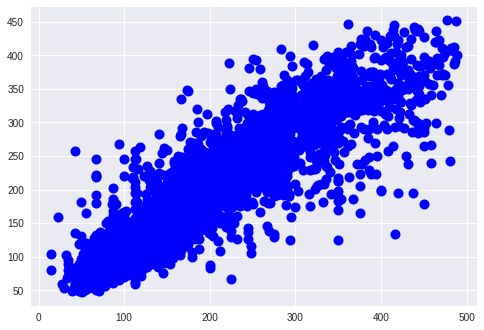

In [36]:
plt.scatter(y_test, y_pred, color='blue', linewidth=3)

In [15]:
for feature in all_features:
  target = 'median_house_value'
  X_train, X_test, y_train, y_test = train_test_splitter(california_housing_dataframe, [feature], target)
  trained_model = build_model(X_train, y_train, LinearRegression())
  y_pred, error_train, error_test = test_model(X_train, y_train, X_test, y_test, trained_model)
  print(feature)
  print('root mean squared error on train data %.2f' % error_train)
  print('root mean squared error on test data %.2f' % error_test)

model coefficient: [-2.40231574]
longitude
root mean squared error on train data 116.38
root mean squared error on test data 114.31
model coefficient: [-7.68167913]
latitude
root mean squared error on train data 115.14
root mean squared error on test data 113.60
model coefficient: [1.03277208]
housing_median_age
root mean squared error on train data 114.86
root mean squared error on test data 116.69
model coefficient: [0.00708305]
total_rooms
root mean squared error on train data 114.37
root mean squared error on test data 116.81
model coefficient: [0.01213551]
total_bedrooms
root mean squared error on train data 115.80
root mean squared error on test data 116.05
model coefficient: [-0.00259605]
population
root mean squared error on train data 115.53
root mean squared error on test data 117.14
model coefficient: [0.01763977]
households
root mean squared error on train data 116.29
root mean squared error on test data 114.18
model coefficient: [42.02747956]
median_income
root mean square

In [9]:
#use linear regression as the model
X_full = california_housing_dataframe.drop('median_house_value', axis = 1)
y_full = california_housing_dataframe['median_house_value']
lr = LinearRegression()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X_full, y_full)
 
print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), all_features)))

Features sorted by their rank:
[(1, 'longitude'), (2, 'latitude'), (3, 'median_income'), (4, 'housing_median_age'), (5, 'total_bedrooms'), (6, 'households'), (7, 'population'), (8, 'total_rooms')]


Predict with created model

In [58]:
y_from_train = model.predict(X_train)
print('mean squared error on train data %f' % metrics.mean_squared_error(y_train, y_from_train))
print('root mean squared error on train data %f' % math.sqrt(metrics.mean_squared_error(y_train, y_from_train)))

y_predict = model.predict(X_test)
print('mean squared error on test data : %f' % metrics.mean_squared_error(y_predict, y_test))
print('root mean squared error on test data : %f' % math.sqrt(metrics.mean_squared_error(y_predict, y_test)))

mean squared error on train data 13138.342613
root mean squared error on train data 114.622610
mean squared error on test data : 13470.294258
root mean squared error on test data : 116.061597


In [51]:
model.coef_

array([-4.30553965e+01, -4.29244508e+01,  1.13036256e+00, -8.15535401e-03,
        1.19318069e-01, -3.57601492e-02,  3.61132685e-02,  4.00328551e+01])

In [53]:
X_test.shape

(4250, 8)

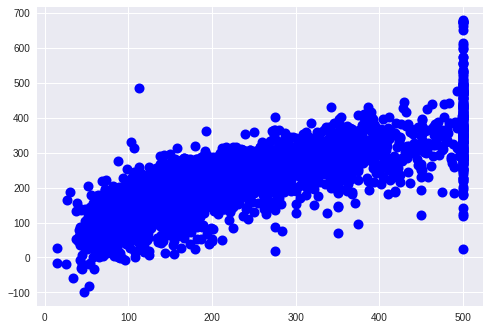

In [55]:
#plt.scatter(X_test, y_test,  color='black')
plt.scatter(y_test, y_predict, color='blue', linewidth=3)

In [24]:
y_predictions = model.predict(X_data)
mean_squared_error = metrics.mean_squared_error(y_predictions, y_data)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 13441.009
Root Mean Squared Error (on training data): 115.935


In [25]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 115.935


In [26]:
X_data.head()
X_data.shape

(17000, 1)

In [0]:
sample_data = california_housing_dataframe.sample(n = 300)
sample_X = sample_data[['population']]
sample_y = sample_data['median_house_value']

sample_X.shape
y_predict = model.predict(sample_X)


#plt.scatter(sample_X, sample_y)
#plt.plot([sample_X.min(), y_0], [sample_X.max(), y_1], c = 'r')

In [28]:
print(model.coef_)
print(model.intercept_)

[-0.00281408]
211.32385385695704


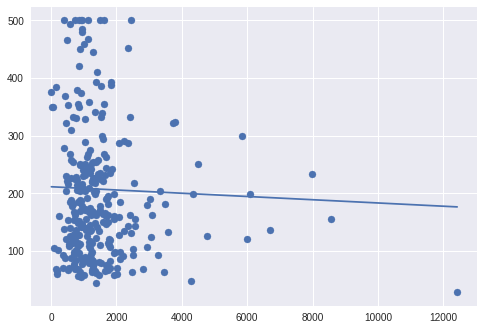

In [29]:
x_0 = sample_data["population"].min()
x_1 = sample_data["population"].max()

x_test = np.linspace(x_0, x_1, 100)
y_test = [model.coef_*x + model.intercept_ for x in x_test]
plt.scatter(sample_data['population'], sample_data['median_house_value'])
plt.plot(x_test, y_test)


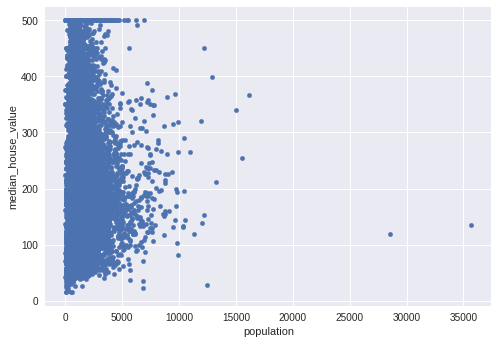

In [40]:
california_housing_dataframe.plot.scatter(x = 'population', y = 'median_house_value')

The objective now is to try and improve R2 value for the model. Modify previous functions to achieve this